In [30]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# given a sequence of visited nodes (path), return the total distance
def total_distance(sequence,D):
    return sum(D[sequence[i], sequence[i+1]] for i in range(len(sequence)-1))

# given a sequence of visited nodes (path), remove all the elements between repeated nodes
def simplify_sequence(sequence):
    result = []
    i = 0
    while i < len(sequence):
        if sequence[i] in sequence[i+1:]:          # if the current node is repeated
            i = sequence.index(sequence[i], i+1)   # find the next index of the repeated node
        else:
            result.append(sequence[i])            # if the current node is not repeated, append it to the simplified sequence
            i += 1
    return result
            
# branch decision rule for the ant
def branch_decision(i,T,D,M,alpha,beta):
    possible_next = np.where(M[i] == 1)[0]               # can only move to the nodes that are connected to the current node
    probability_next = np.zeros(len(possible_next))      # probability of moving to each of the possible next nodes
    for j in range(len(possible_next)):
        probability_next[j] = T[i,possible_next[j]]**alpha * (1/D[i,possible_next[j]])**beta   # formula for the probability of moving to each of the possible next nodes
    probability_next = probability_next / sum(probability_next)                                # normalize the probabilities
    return np.random.choice(possible_next, p=probability_next)

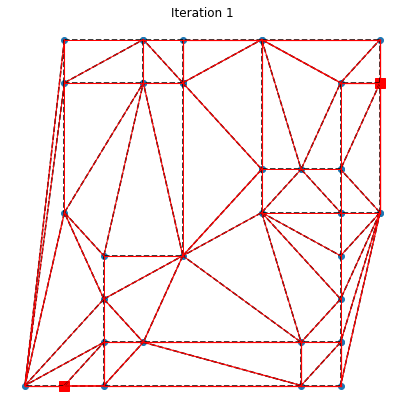

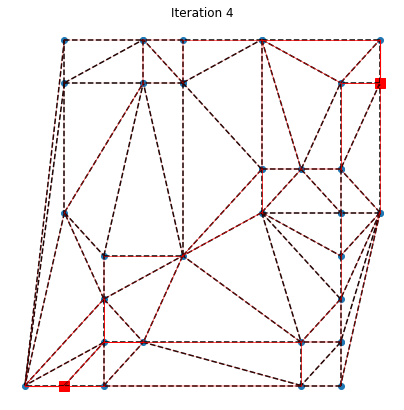

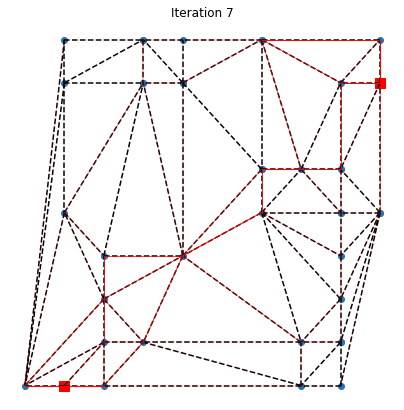

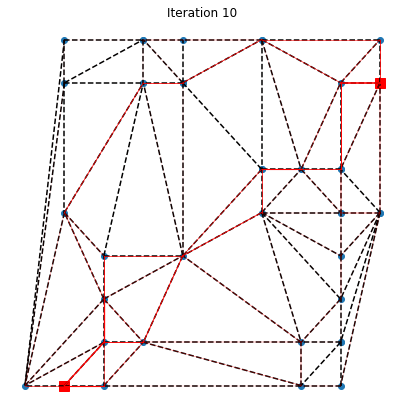

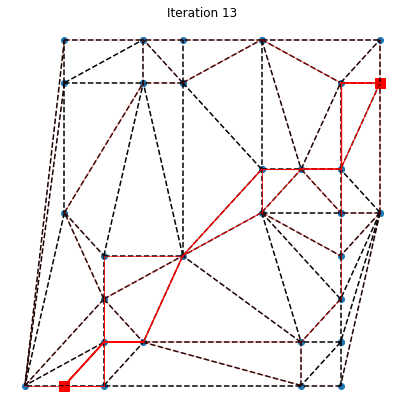

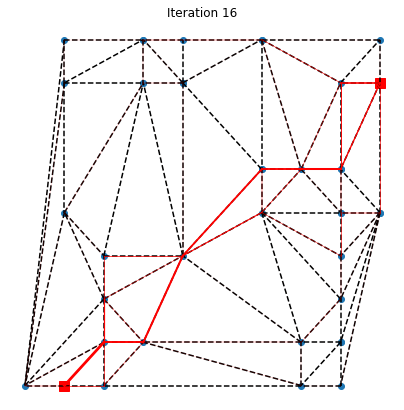

In [45]:
n = 20             # number of ants
alpha = 0.8        # alpha parameter
beta = 1         # beta parameter
rho = 0.5         # rho parameter
max_steps = 80   # maximum number of steps
number_of_iterations = 16 # number of iterations

N = 40  # number of nodes
probability_next = 0.1  # probability of edge

# generate N points at random positions (x,y) with x,y in [0,N] 
r = np.random.randint(0, 10, size=(N, 2)) # Nx2 array

# connect the generated points by a Delaunay triangulation
tri = Delaunay(r)

# create the corresponding adjacency matrix
M = np.zeros((N, N))
for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i+1, len(simplex)):
            M[simplex[i], simplex[j]] = 1
            M[simplex[j], simplex[i]] = 1
    

# define the Euclidean distance all points in r 
D = np.zeros((N, N))
for i in range(N):
    for j in range(i+1,N):
        D[i,j] = np.linalg.norm(r[i]-r[j])
        D[j,i] = D[i,j]

# make the distance inf for points that are not connected
for i in range(N):
    for j in range(i+1,N):
        if M[i,j] == 0:
            D[i,j] = np.inf
            D[j,i] = np.inf

T = M   # initialize the Pheromone matrix, initially equal to the adjacency matrix

distance_bird = 0 
while distance_bird < 7:              # we don't want the starting and the target node to be too close
    # decide a starting node s
    s = np.random.randint(0, N)
    # decide a target node t
    t = np.random.randint(0, N)
    distance_bird = np.sqrt((r[t,0] - r[s,0])**2 + (r[t,1] - r[s,1])**2)

for iteration in range(number_of_iterations):
    # initialize the paths of the ants
    T = T*(1-rho)
    paths = []
    for i in range(n):
        paths.append([s])
        for step in range(max_steps):
            next_node = branch_decision(paths[i][-1], T, D, M, alpha, beta)
            paths[i].append(next_node)
            if next_node == t:
                break
    
    # check if the target node is in the path of any of the ants
    for i in range(n):
        if t in paths[i]:
            paths[i] = simplify_sequence(paths[i])
            path_distance = total_distance(paths[i],D)
            for j in range(len(paths[i])-1):
                T[paths[i][j],paths[i][j+1]] += 1/path_distance
                T[paths[i][j+1],paths[i][j]] += 1/path_distance
    if iteration % 3 == 0:
        plt.figure(figsize=(7,7))
        plt.plot(r[:,0], r[:,1], 'o')
        plt.plot(r[s,0], r[s,1], 's', color='red', markersize=10)
        plt.plot(r[t,0], r[t,1], 's', color='red', markersize=10)
        for i in range(N):
            for j in range(i+1,N):
                if M[i,j] == 1:
                    plt.plot([r[i,0], r[j,0]], [r[i,1], r[j,1]],'k--')


        for i in range(N):
            for j in range(i+1,N):
                plt.plot([r[i,0], r[j,0]], [r[i,1], r[j,1]],'r',linewidth=T[i,j]*2)
        plt.title('Iteration ' + str(iteration+1))
        plt.axis('off')
        plt.show()         
            



